# DBRITZ'S RNN (FIXING CODE ERROR, NEW DATA)

## NUMPY-BASED RNN

### A. FACILITIES

In [3]:
# BUILD-IN FACILITIES
import csv, itertools, operator, nltk, sys
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
# DBRITZ HOMEBREW
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)
def save_model_parameters_theano(outfile, model):
    U, V, W = model.U.get_value(), model.V.get_value(), model.W.get_value()
    np.savez(outfile, U=U, V=V, W=W)
    print "Saved model parameters to %s." % outfile
def load_model_parameters_theano(path, model):
    npzfile = np.load(path)
    U, V, W = npzfile["U"], npzfile["V"], npzfile["W"]
    model.hidden_dim = U.shape[0]
    model.word_dim = U.shape[1]
    model.U.set_value(U)
    model.V.set_value(V)
    model.W.set_value(W)
    print "Loaded model parameters from %s. hidden_dim=%d word_dim=%d" % (path, U.shape[0], U.shape[1])

### B. DATA PREPROCESSING

In [86]:
# ACCESSORIES
vocabSize = 8000
unknownTK = "UNK"
sentStartTK = "SENT_START"
sentEndTK = "SENT_END"

In [87]:
# LOAD DATA
from nltk.corpus import brown
sentsBrown = brown.sents(categories='news')
    # format: [u'..', u'..', ...].
sentsBrownStr = [' '.join([str(w.lower()) for w in sent]) for sent in sentsBrown]
    # format: ['..lower', ...].
sentsBrownStr = ["%s %s %s" % (sentStartTK, sent, sentEndTK) for sent in sentsBrownStr]
    # format: ['SENT_START ... SENT_END', ...].
sentsBrownTK = [nltk.word_tokenize(sent) for sent in sentsBrownStr] 
    # format: [['SENT_START', '..', '..', ..., 'SENT_END'], ...].

In [88]:
# CREATE WORD FREQ. DIST. 
# CREAT WORD-INDEX TRANSLATION
wordFdist = nltk.FreqDist(itertools.chain(*sentsBrownTK))
    # feature: itertools.chain creates an object, on which, on calling .next(), a token is yielded.
vocab = wordFdist.most_common(vocabSize-1)
    # format: [(w1, w1Freq), ...].
    # original vocabulary size: 12639, select top 8000 for the convenience of keeping track of computation.
    # most freq.: 'the', least freq.: 'buffets'.
indexToWord = [w[0] for w in vocab]
    # format: [w1, w2, ...].
indexToWord.append(unknownTK)
wordToIndex = dict([(w,i) for i,w in enumerate(indexToWord)])
    # format: {w1:idx1, ...}.

In [89]:
# UNKNOWN WORDS -> UNK
for i,sent in enumerate(sentsBrownTK): # replacing all unknown words with unknownTK.
    sentsBrownTK[i] = [w if w in wordToIndex else unknownTK for w in sent]

In [90]:
# WORD -> INDEX IN VOCAB
X_train = np.asarray([[wordToIndex[w] for w in sent[:-1]] for sent in sentsBrownTK]) # excludes SENT_END.
y_train = np.asarray([[wordToIndex[w] for w in sent[1:]] for sent in sentsBrownTK]) # excludes SENT_START.

In [97]:
print X_train[0]
print y_train[0]

[2, 0, 835, 143, 596, 202, 26, 222, 32, 1041, 5, 623, 17, 551, 702, 241, 1862, 13, 77, 680, 15, 11, 94, 3462, 201, 320, 4]
[0, 835, 143, 596, 202, 26, 222, 32, 1041, 5, 623, 17, 551, 702, 241, 1862, 13, 77, 680, 15, 11, 94, 3462, 201, 320, 4, 3]


### C. RNN

In [198]:
from IPython.display import display, Image
rnn_architecture = Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/RNN/DATA/rnn_architecture.png', width="40%")
state_output_computation = Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/RNN/DATA/state_output_computation.png', width="20%")
params_dimensions = Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/RNN/DATA/params_dimensions.png', width="12%")
neg_log_function = Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/RNN/DATA/neg_log_function.png', width="20%")
grad_check = Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/RNN/DATA/grad_check.png', width="20%")
print 'IMAGE IMPORTED!'

IMAGE IMPORTED!


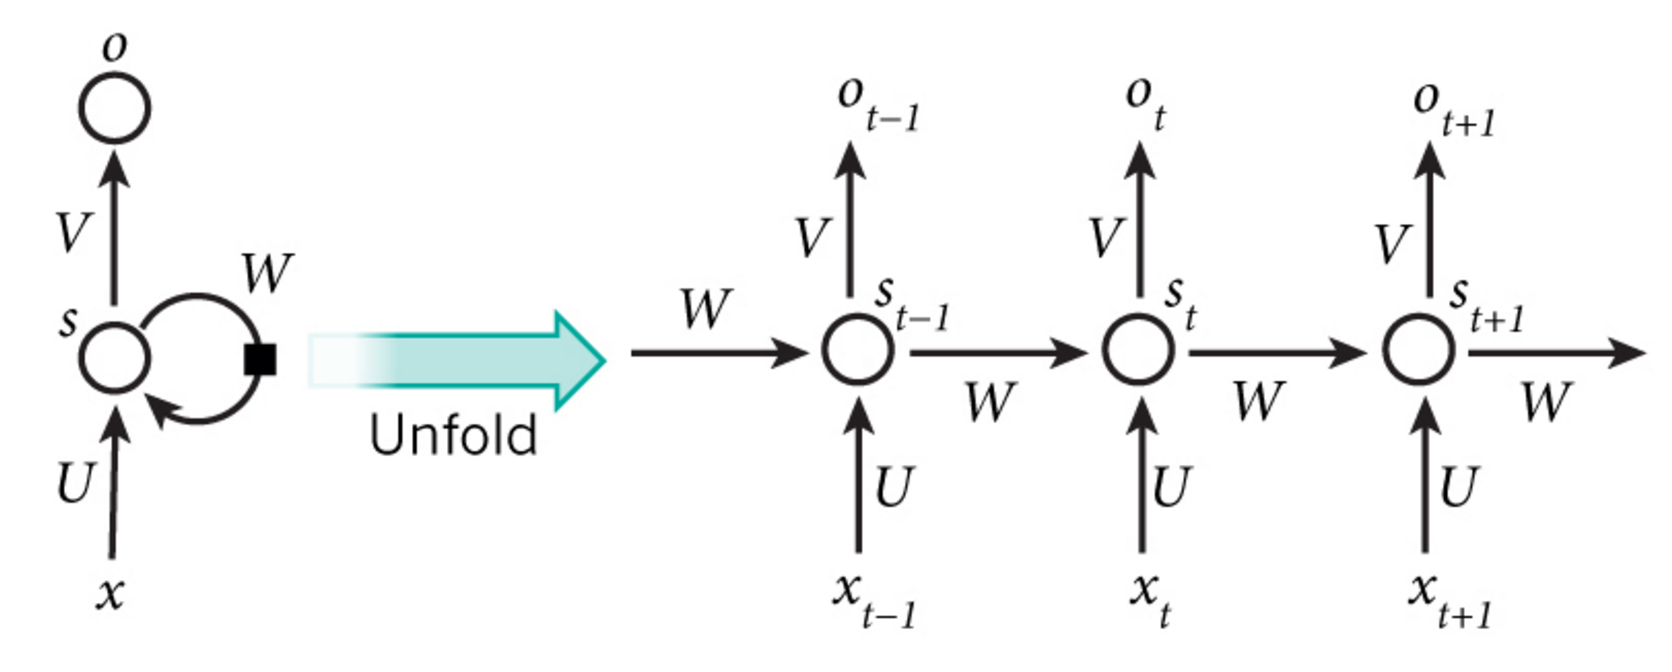

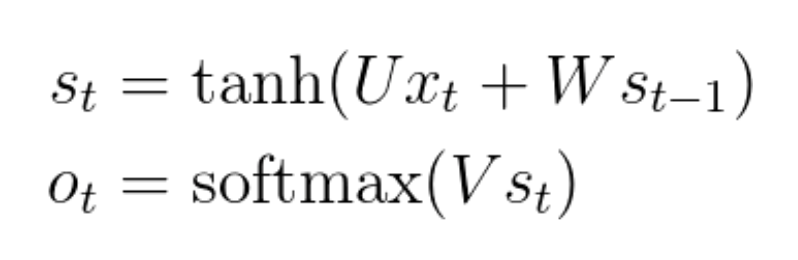

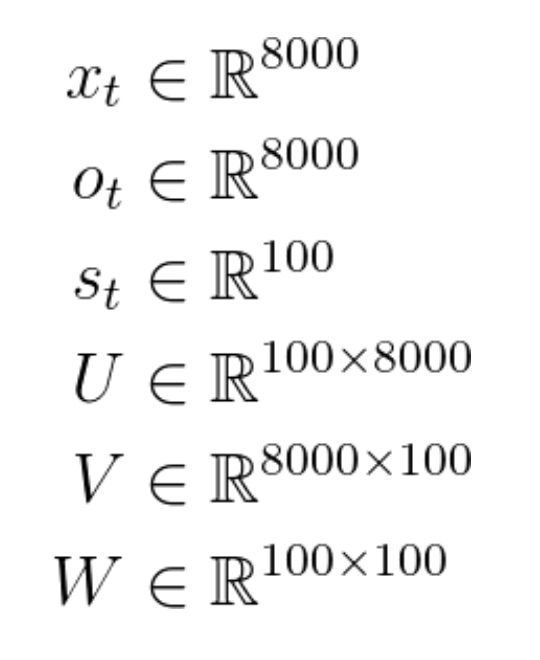

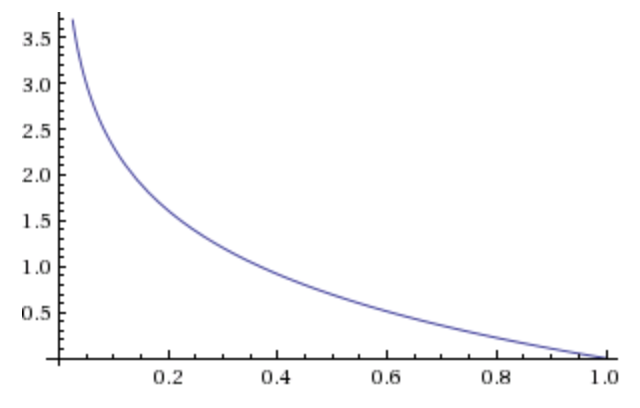

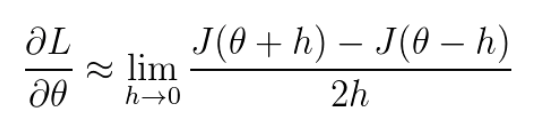

In [200]:
display(rnn_architecture)
display(state_output_computation)
display(params_dimensions)
display(neg_log_function)
display(grad_check)

In [270]:
## RNN PROPER
class RNNNumpy:
    
    def __init__(self, wordDim, hiddenDim=100, bpttTruncate=4):
        self.wordDim = wordDim
        self.hiddenDim = hiddenDim
        self.bpttTruncate = bpttTruncate
        # randomly initialize network params.
        self.U = np.random.uniform(-np.sqrt(1./wordDim), np.sqrt(1./wordDim), (hiddenDim, wordDim))
            # input: U*x = 100*8000 * 8000*1 = 100*1 (word->hidden projection).
        self.V = np.random.uniform(-np.sqrt(1./wordDim), np.sqrt(1./wordDim), (wordDim, hiddenDim))
            # output: V*s = 8000*100 * 100*1 = 8000*1 (hidden->word projection).
        self.W = np.random.uniform(-np.sqrt(1./wordDim), np.sqrt(1./wordDim), (hiddenDim, hiddenDim))
            # inter-node: W*s = 100*100 * 100*1 = 100*1 (hidden->hidden projection).
    
    def forward_propagation(self, sent):
        T = len(sent) # time steps = number of words in a sent.
        s = np.zeros((T+1, self.hiddenDim)) # storage: params for each word (8001*100).
        s[-1] = np.zeros(self.hiddenDim) # add 1 element for initial hidden.
        o = np.zeros((T, self.wordDim)) # storage: outputs at each step (8000*8000).
        for t in np.arange(T):
            s[t] = np.tanh(self.U[:,sent[t]] + self.W.dot(s[t-1])) # U[:,sent[t]]: assuming one-hot word coding.
                                                                   # NB: FOR WORD2VEC IMPL., NEED REVISE!!!
            o[t] = softmax(self.V.dot(s[t]))
        return [o, s]
    
    def predict(self, sent):
        o, s = self.forward_propagation(sent)
        return np.argmax(o, axis=1) # axis=1: return row-maxes (i.e. max in 100D softmax output).
    
    def calculate_total_loss(self, sents, sentsNextWords):
        L = 0
        for i in np.arange(len(sentsNextWords)): 
            # for each sentence, compute loss: sum of loss of Pr(w_i|w_i-1) for all words in the sentence.
            o, s = self.forward_propagation(sents[i]) # make prediction using current sentence.
            correctPreds = o[np.arange(len(sentsNextWords[i])), sentsNextWords[i]]
                #                          ^                         ^
                #                          |                         |
                #     at time step i (i.e. on the current word)  prediction
            L += -1 * np.sum(np.log(correctPreds))
        return L
    
    def calculate_loss(self, sents, sentsNextWords):
        N = np.sum((len(sentsNextWords_i) for sentsNextWords_i in sentsNextWords))
            # N = the total number of words in training sentences.
        return self.calculate_total_loss(sents, sentsNextWords) / N # average loss, normalized by total # of words.
    
    def bptt(self, sent, sentNextWords): 
        T = len(sentNextWords)
        # Perform forward propagation
        o, s = self.forward_propagation(sent)
        # We accumulate the gradients in these variables
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        delta_o = o
        delta_o[np.arange(len(sentNextWords)), sentNextWords] -= 1.
        # For each output backwards...
        for t in np.arange(T)[::-1]:
            dLdV += np.outer(delta_o[t], s[t].T)
            # Initial delta calculation
            delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for bptt_step in np.arange(max(0, t-self.bpttTruncate), t+1)[::-1]:
                # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
                dLdW += np.outer(delta_t, s[bptt_step-1])              
                dLdU[:,sent[bptt_step]] += delta_t
                # Update delta for next step
                delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
        return [dLdU, dLdV, dLdW]
    
    # NB: only run this on small-vocabed data!!!
    def gradient_check(self, sent, sentNextWords, h=.001, errorThreshold=.01): # h=change magnitude; eT: true-hat diff.
        # compute gradients.
        bpffGrads = self.bptt(sent, sentNextWords)
        # list all parameters to be checked.
        params = ['U', 'V', 'W']
        # gradient check for each param.
        for pidx,pname in enumerate(params):
            # get actual param value from model, e.g. W.
            param = operator.attrgetter(pname)(self) # self refers back to current RNNNumpy, W's a param storage.
            # iterate over each element of param matrix.
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                ix = it.multi_index
                originalVal = param[ix] # save original value.
                param[ix] = originalVal + h
                gradPlus = self.calculate_total_loss([sent], [sentNextWords])
                param[ix] = originalVal - h
                gradMinus = self.calculate_total_loss([sent], [sentNextWords])
                estimatedGrad = (gradPlus - gradMinus) / (2*h)
                # rest param to original value.
                param[ix] = originalVal
                # actual gradient calculated.
                actualGrad = bpffGrads[pidx][ix]
                # compute relative error: (|x-y|/(|x|+|y|))
                relError = np.abs(actualGrad-estimatedGrad) / (np.abs(actualGrad)+np.abs(estimatedGrad))
                if relError > errorThreshold: # report error (simplified).
                    print "ERROR OVER THRESHOLD!"
                it.iternext()
        print "GRAD CHECK PASSED"

In [258]:
# USAGE I: FORWARD PROPAGATION
np.random.seed(0)
model = RNNNumpy(vocabSize)
print "Sample Sent: ", [indexToWord[w] for w in X_train[10]]
print "Sample Sent Length: ", len(X_train[10])
o, s = model.forward_propagation(X_train[10])
print o.shape
print o
print "EXP: for each word in the sample sentence (15-word),\
 model makes 8,000 predictions representing the probabilities of the next word."

Sample Sent:  ['SENT_START', 'it', 'urged', 'that', 'the', 'city', '``', 'take', 'steps', 'to', 'remedy', "''", 'this', 'problem', '.']
Sample Sent Length:  15
(15, 8000)
[[ 0.00012496  0.00012495  0.00012509 ...,  0.00012504  0.00012499
   0.00012503]
 [ 0.000125    0.00012497  0.00012495 ...,  0.00012499  0.00012506
   0.00012506]
 [ 0.00012501  0.00012504  0.00012494 ...,  0.00012493  0.00012498
   0.00012497]
 ..., 
 [ 0.00012494  0.00012501  0.00012499 ...,  0.00012504  0.00012504
   0.00012496]
 [ 0.00012492  0.00012501  0.000125   ...,  0.00012498  0.00012502
   0.00012497]
 [ 0.00012501  0.00012508  0.00012499 ...,  0.00012501  0.00012496
   0.00012505]]
EXP: for each word in the sample sentence (15-word), model makes 8,000 predictions representing the probabilities of the next word.


In [259]:
# USAGE II: PREDICTION
predictions = model.predict(X_train[10]) # indices of next words of words in Sample Sent.
print predictions.shape
print "Sample Sent: ", [indexToWord[w] for w in X_train[10]]
print "Predicted Next Words: ", [indexToWord[i] for i in predictions]

(15,)
Sample Sent:  ['SENT_START', 'it', 'urged', 'that', 'the', 'city', '``', 'take', 'steps', 'to', 'remedy', "''", 'this', 'problem', '.']
Predicted Next Words:  ['illegal', '3:57', 'using', 'paschal', 'erred', 'agree', 'wait', 'peterson', 'actually', 'rising', 'loss', 'shopping', 'him', 'teacher', '600']


In [253]:
%%time
# USAGE III: COMPUTE LOSS
print "Expected Loss for Random Predictions: %f" % np.log(vocabSize)
    # random prediction: assuming C words in vocabulary, N total tokens, 
    #  each word contributes then -(1/N)*log(1/C) in loss, 
    #  total loss will therefore be N*[-(1/N)*log(1/C)] = log(C)
print "Actual Loss: %f" % model.calculate_loss(X_train[:1000], y_train[:1000])

Expected Loss for Random Predictions: 8.987197
Actual Loss: 8.987223
CPU times: user 9.69 s, sys: 574 ms, total: 10.3 s
Wall time: 5.69 s


In [ ]:
%%time
# USAGE IV: BPTT

In [260]:
%%time
# USAGE V: GRADIENT CHECK
gradCheckVocabSize = 100
np.random.seed(0)
model = RNNNumpy(gradCheckVocabSize, 10, bpttTruncate=1000)
model.gradient_check([0,1,2,3], [1,2,3,4])

/Users/jacobsw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:97: RuntimeWarning: invalid value encountered in double_scalars


GRAD CHECK PASSED
CPU times: user 420 ms, sys: 4.37 ms, total: 425 ms
Wall time: 424 ms


### D. SGD

In [269]:
# STOCHASTIC GRADIENT DESCENT
class SGDNumpy:
    
    def __init__(self, model):
        self.model = model

    def numpy_sgd_step(self, sent, sentNextWords, learningRate): # 1 step in SGD
        # calculate gradients.
        dLdU, dLdV, dLdW = self.model.bptt(sent, sentNextWords)
        # change params according to gradients.
        #  NB: += for maximization, -= for minimization.
        self.model.U -= learningRate * dLdU
        self.model.V -= learningRate * dLdV
        self.model.W -= learningRate * dLdW
    
    def train_with_sgd(self, X_train, y_train, learningRate=.005, nepoch=100, lossAfter=5):
        # lossAfter: evaluate loss after this many epochs.
        losses = []
        numExamplesSeen = 0
        for epoch in range(nepoch):
            if (epoch % lossAfter == 0): # time to evaluate loss.
                loss = self.model.calculate_loss(X_train, y_train)
                losses.append((numExamplesSeen, loss))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print "%s: Loss After numExamplesSeen=%d epoch=%d: %f" % (time, numExamplesSeen, epoch, loss)
                # adjust learning rate if loss increase.
                if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                    #           ^                     ^
                    #           |                     |
                    #   there's at least 1 prev.  current > prev.
                    learningRate = learningRate*.5
                    print "Setting Learning Rate to %f" % learningRate
                sys.stdout.flush()
            # for each training example.
            for i in range(len(y_train)):
                self.numpy_sgd_step(X_train[i], y_train[i], learningRate)
                numExamplesSeen += 1

In [261]:
%%time
# USAGE VIa: SGD STEP
model = RNNNumpy(vocabSize)
sgd = SGDNumpy(model)
sgd.numpy_sgd_step(X_train[10], y_train[10], .005)

CPU times: user 90.3 ms, sys: 21 ms, total: 111 ms
Wall time: 101 ms


In [268]:
%%time
# USAGE VIb: SGD ALL
model = RNNNumpy(vocabSize)
sgd = SGDNumpy(model)
losses = sgd.train_with_sgd(X_train[:100], y_train[:100], nepoch=5, lossAfter=1)

2016-06-05 18:58:53: Loss After numExamplesSeen=0 epoch=0: 8.987190
2016-06-05 18:59:03: Loss After numExamplesSeen=100 epoch=1: 8.986924
2016-06-05 18:59:13: Loss After numExamplesSeen=200 epoch=2: 8.986496
2016-06-05 18:59:23: Loss After numExamplesSeen=300 epoch=3: 8.985620
2016-06-05 18:59:33: Loss After numExamplesSeen=400 epoch=4: 8.983645
CPU times: user 45.1 s, sys: 9.72 s, total: 54.9 s
Wall time: 50.5 s
